In [3]:
import pandas as pd # data preprocessing
import itertools # confusion matrix
import string
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt


In [1]:
!wget https://raw.githubusercontent.com/uddiptta15/AI-based-drug-recommendation-system/main/drugsComTest_raw.tsv

--2024-04-25 17:09:04--  https://raw.githubusercontent.com/uddiptta15/AI-based-drug-recommendation-system/main/drugsComTest_raw.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26072128 (25M) [text/plain]
Saving to: ‘drugsComTest_raw.tsv’

drugsComTest_raw.ts 100%[===================>]  24.86M  --.-KB/s    in 0.1s    

2024-04-25 17:09:05 (193 MB/s) - ‘drugsComTest_raw.tsv’ saved [26072128/26072128]



In [11]:
df=pd.read_csv('/content/drugsComTest_raw.tsv', sep='\t')

In [19]:
df.head()

,,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,"February 28, 2012",22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,"May 17, 2009",17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,"September 29, 2017",3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,"March 5, 2017",35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,"October 22, 2015",4


let’s check the distribution of medical conditions in the dataset

In [20]:
df.condition.value_counts()

condition
Birth Control              8918
Depression                 2869
Pain                       1952
Anxiety                    1759
Acne                       1717
                           ... 
Dermatomyositis               1
Coronary Artery Disease       1
Anthrax                       1
Pulmonary Edema               1
Strongyloidiasis              1
Name: count, Length: 700, dtype: int64

To make it simple we will select the top 5 medical conditions

In [21]:
df_train = df[(df['condition']=='Birth Control') | (df['condition']=='Depression') | (df['condition']=='Pain')| (df['condition']=='Anxiety')| (df['condition']=='Acne')]

Now will remove other features from the dataset

In [23]:
X = df_train.drop([' ','drugName','rating','date','usefulCount'],axis=1)

In [ ]:
X.head()

,condition,review
2,Birth Control,"""I used to take another oral contraceptive, wh..."
3,Birth Control,"""This is my first time using any form of birth..."
9,Birth Control,"""I had been on the pill for many years. When m..."
11,Depression,"""I have taken anti-depressants for years, with..."
14,Birth Control,"""Started Nexplanon 2 months ago because I have..."


remove double quotes from the dataset

In [24]:
for i, col in enumerate(X.columns):
    X.iloc[:, i] = X.iloc[:, i].str.replace('"', '')

In [25]:
X.head()

,condition,review
0,Depression,I&#039;ve tried a few antidepressants over the...
4,Birth Control,I have been on this birth control for one cycl...
5,Birth Control,I was on this pill for almost two years. It do...
13,Acne,So I was on Ginanvi for about 3 months before ...
26,Birth Control,I absolutely love this product and recommend t...


In [26]:
!pip install nltk
from bs4 import BeautifulSoup
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [28]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def review_to_words(raw_review):
    # 1. Delete HTML
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords
    meaningful_words = [w for w in words if not w in stop]
    # 6. lemmitization
    lemmitize_words = [lemmatizer.lemmatize(w) for w in meaningful_words if w]
    # 7. space join words
    return( ' '.join(lemmitize_words))

X['review_clean'] = X['review'].apply(review_to_words)

#creating feature and target variable
X_feat=X['review_clean']
y=X['condition']

X.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-28-42440544e03a>:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review, 'html.parser').get_text()


,condition,review,review_clean
0,Depression,I&#039;ve tried a few antidepressants over the...,tried antidepressant year citalopram fluoxetin...
4,Birth Control,I have been on this birth control for one cycl...,birth control one cycle reading review type si...
5,Birth Control,I was on this pill for almost two years. It do...,pill almost two year work far getting pregnant...
13,Acne,So I was on Ginanvi for about 3 months before ...,ginanvi month switched pill due high cost gina...
26,Birth Control,I absolutely love this product and recommend t...,absolutely love product recommend everyone kno...


Train Test split

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_feat, y,stratify=y,test_size=0.2, random_state=90)

vectorize the data

In [49]:
tfidf_vectorizer2 = TfidfVectorizer(max_df=0.8, ngram_range=(1,2))
tfidf_train_2 = tfidf_vectorizer2.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer2.transform(X_test)

Creating features and Target Variable

In [31]:
!pip install scikit-plot


In [50]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [51]:
count_vectorizer = CountVectorizer(stop_words='english')

count_train = count_vectorizer.fit_transform(X_train)

count_test = count_vectorizer.transform(X_test)

In [34]:
!pip install scikit-learn
from sklearn import metrics

Machine Learning Model : Naive Bayes

accuracy:   0.918
Confusion matrix, without normalization


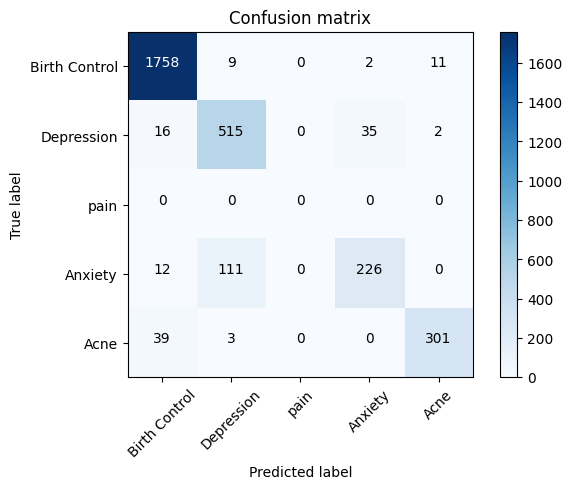

In [52]:
from sklearn.metrics import accuracy_score
mnb = MultinomialNB()
mnb.fit(count_train, y_train)
pred = mnb.predict(count_test)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','pain','Anxiety','Acne'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','pain','Anxiety','Acne'])

Machine Learning Model : Passive Aggressive Classifier

accuracy:   0.886
Confusion matrix, without normalization


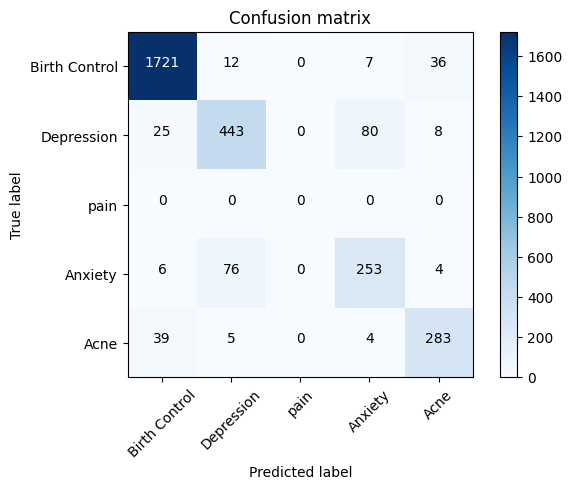

In [37]:
from sklearn.linear_model import PassiveAggressiveClassifier,LogisticRegression

passive = PassiveAggressiveClassifier()
passive.fit(count_train, y_train)
pred = passive.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','pain','Anxiety','Acne'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','pain','Anxiety','Acne'])

TFIDF

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_train_2 = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer.transform(X_test)

Naive Bayes

accuracy:   0.803
Confusion matrix, without normalization


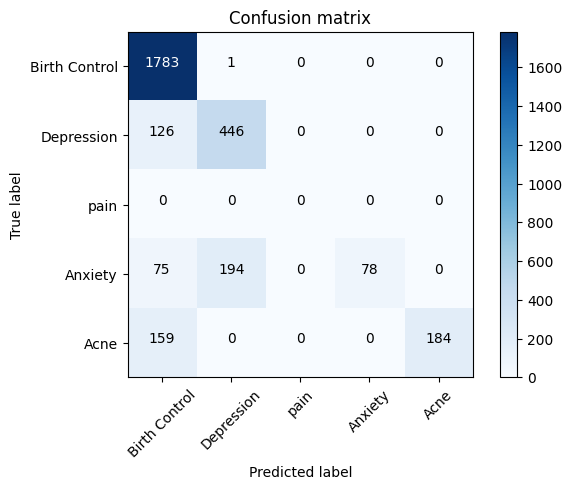

In [39]:
mnb_tf = MultinomialNB()
mnb_tf.fit(tfidf_train_2, y_train)
pred = mnb_tf.predict(tfidf_test_2)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','pain','Anxiety','Acne'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','pain','Anxiety','Acne'])

TFIDF

accuracy:   0.897
Confusion matrix, without normalization


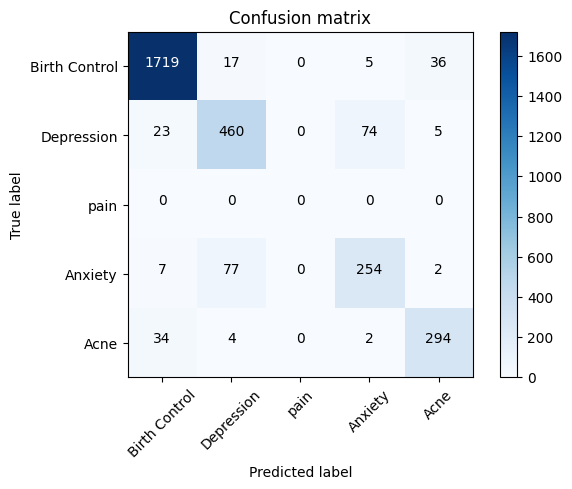

In [40]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train, y_train)
pred = pass_tf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','pain','Anxiety','Acne'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','pain','Anxiety','Acne'])

TFIDF-Bigrams

In [41]:
tfidf_vectorizer2 = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,2))
tfidf_train_2 = tfidf_vectorizer2.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer2.transform(X_test)

accuracy:   0.922
Confusion matrix, without normalization


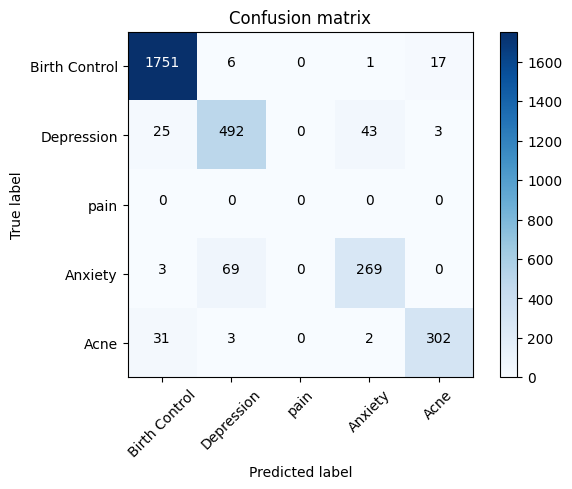

In [42]:
pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_2, y_train)
pred = pass_tf.predict(tfidf_test_2)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','pain','Anxiety','Acne'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','pain','Anxiety','Acne'])

TFIDF-Trigrams

accuracy:   0.924
Confusion matrix, without normalization


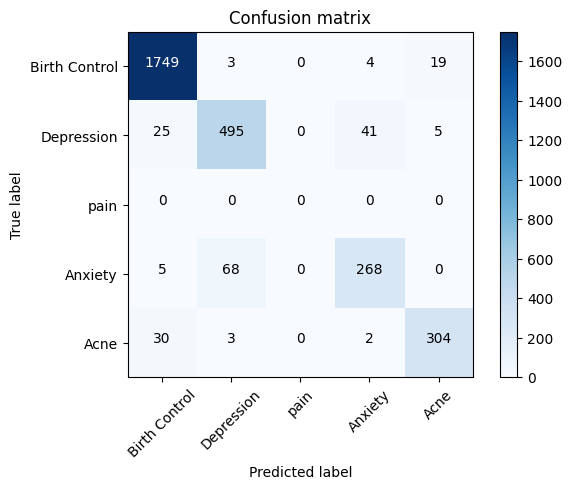

In [43]:
tfidf_vectorizer3 = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,3))
tfidf_train_3 = tfidf_vectorizer3.fit_transform(X_train)
tfidf_test_3 = tfidf_vectorizer3.transform(X_test)

pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_3, y_train)
pred = pass_tf.predict(tfidf_test_3)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','pain','Anxiety','Acne'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','pain','Anxiety','Acne'])

Most Informative Feature

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [45]:
def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=10):
    labelid = list(classifier.classes_).index(classlabel)
    feature_names = tfidf_vectorizer2.get_feature_names_out()
    topn = sorted(zip(classifier.coef_[labelid], feature_names))[-n:]

    for coef, feat in topn:
        print (classlabel, feat, coef)



most_informative_feature_for_class(tfidf_vectorizer2, pass_tf, 'Birth Control')

Birth Control husband actually 2.6637511190104814
Birth Control rate medicine 2.6959162639948797
Birth Control episode started 2.7456244856688854
Birth Control waking constantly 2.8449801530266927
Birth Control creates insatiable 3.0607461646376732
Birth Control didnt worry 4.021579252946796
Birth Control die long 4.039324589254475
Birth Control jul omg 4.262780222418871
Birth Control docotr 4.924853557699796
Birth Control irritability cramping 5.233329490356071


In [46]:
most_informative_feature_for_class(tfidf_vectorizer2, pass_tf, 'Depression')

Depression lexapro medicine 2.1113939497423035
Depression exact timing 2.637449581754054
Depression speak long 2.6542461809571907
Depression mirena awhile 2.877361046349434
Depression received free 3.129499804502321
Depression able benefit 3.2198490813807026
Depression fine panic 3.445499506233353
Depression pushed week 3.5800900536283358
Depression bleed cramp 5.047707047463615
Depression miracle pill 9.51060235746359


In [54]:
most_informative_feature_for_class(tfidf_vectorizer2, pass_tf, 'Pain')

Pain everybody happy 1.6973586893693628
Pain awful get 1.7871692081431731
Pain pill wonderful 2.0508614387992687
Pain said tough 2.216353999312565
Pain sticking staying 2.2751570878127843
Pain percocet also 2.2908228232986954
Pain wind back 2.3368744397295207
Pain breaking pill 2.416511985402705
Pain mare face 2.475682483077255
Pain maybe nothing 2.959878013815385


In [55]:
most_informative_feature_for_class(tfidf_vectorizer2, pass_tf,'Anxiety')

Anxiety period date 1.7094556595271118
Anxiety coworkers say 1.7683262810701512
Anxiety effexor cymbalta 1.768597236416679
Anxiety find birth 1.8205803816664465
Anxiety used new 1.9741822978405514
Anxiety business 2.353259091953689
Anxiety emotion certainly 2.794936814113321
Anxiety bunch would 4.189978461777727
Anxiety effective prescribed 4.919869159819664
Anxiety bc calling 9.602049129164584


In [56]:
most_informative_feature_for_class(tfidf_vectorizer2, pass_tf,'Acne')

Acne baldness hair 2.3675359527774087
Acne drive absolutely 2.6398651328870932
Acne neuropathy arthritis 2.7329889985800513
Acne peacefulness side 2.8059605930808384
Acne horror found 2.8077665732974135
Acne monthly 2.918425838050881
Acne product face 3.8566493104245354
Acne longer irregular 4.23436226493942
Acne actually hyped 5.336060643112993
Acne adjusted must 7.305022862503037


Sample Predictions

In [57]:
X.tail()

,condition,review,review_clean
49931,Birth Control,I unfortunately had to remove my wonderful IUD...,unfortunately remove wonderful iud forced reso...
49933,Birth Control,So I got Nexplanon just under a year ago. I or...,got nexplanon year ago originally got supposed...
49937,Depression,I have been taking maprotiline for over 35 yea...,taking maprotiline year still taking seemed sh...
49945,Depression,I&#039;m a 19 year old girl and I&#039;ve been...,year old girl suffering major depression socia...
49948,Anxiety,I have a rare disease called Systemic Mastocyt...,rare disease called systemic mastocytosis pres...


In [58]:
def top_drugs_extractor(condition):
    df_top = df[(df['rating']>=9)&(df['usefulCount']>=100)].sort_values(by = ['rating', 'usefulCount'], ascending = [False, False])
    drug_lst = df_top[df_top['condition']==condition]['drugName'].head(3).tolist()
    return drug_lst

In [59]:
def predict_text(lst_text):
    df_test = pd.DataFrame(lst_text, columns = ['test_sent'])
    df_test["test_sent"] = df_test["test_sent"].apply(review_to_words)
    tfidf_bigram = tfidf_vectorizer3.transform(lst_text)
    prediction = pass_tf.predict(tfidf_bigram)
    df_test['prediction']=prediction
    return df_test

In [60]:
sentences = [
  "I have only been on Tekturna for 9 days. The effect was immediate. I am also on a calcium channel blocker (Tiazac) and hydrochlorothiazide. I was put on Tekturna because of palpitations experienced with Diovan (ugly drug in my opinion, same company produces both however). The palpitations were pretty bad on Diovan, 24 hour monitor by EKG etc. After a few days of substituting Tekturna for Diovan, there are no more palpitations.",
    "This is the third med I&#039;ve tried for anxiety and mild depression. Been on it for a week and I hate it so much. I am so dizzy, I have major diarrhea and feel worse than I started. Contacting my doc in the am and changing asap.",
    "I just got diagnosed with type 2. My doctor prescribed Invokana and metformin from the beginning. My sugars went down to normal by the second week. I am losing so much weight. No side effects yet. Miracle medicine for me",

  ]

In [61]:
 tfidf_trigram = tfidf_vectorizer3.transform(sentences)


predictions = pass_tf.predict(tfidf_trigram)

for text, label in zip(sentences, predictions):
    if label=="High Blood Pressure":
        target="High Blood Pressure"
        top_drugs = top_drugs_extractor(label)
        print("text:", text, "\nCondition:", target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()
    elif label=="Depression":
        target="Depression"
        top_drugs = top_drugs_extractor(label)
        print("text:", text, "\nCondition:", target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()
    elif label=="Diabetes, Type 2":
        target="Diabetes, Type 2"
        top_drugs = top_drugs_extractor(label)
        print("text:", text, "\nCondition:", target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()
    else:
        target="Birth Control"
        print("text:", text, "\Condition:", target)
        top_drugs = top_drugs_extractor(label)
        print("text:", text, "\nCondition:", target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()

text: I have only been on Tekturna for 9 days. The effect was immediate. I am also on a calcium channel blocker (Tiazac) and hydrochlorothiazide. I was put on Tekturna because of palpitations experienced with Diovan (ugly drug in my opinion, same company produces both however). The palpitations were pretty bad on Diovan, 24 hour monitor by EKG etc. After a few days of substituting Tekturna for Diovan, there are no more palpitations. \Condition: Birth Control
text: I have only been on Tekturna for 9 days. The effect was immediate. I am also on a calcium channel blocker (Tiazac) and hydrochlorothiazide. I was put on Tekturna because of palpitations experienced with Diovan (ugly drug in my opinion, same company produces both however). The palpitations were pretty bad on Diovan, 24 hour monitor by EKG etc. After a few days of substituting Tekturna for Diovan, there are no more palpitations. 
Condition: Birth Control
Top 3 Suggested Drugs:
Oxycodone
Elavil
Amitriptyline

text: This is the t

In [62]:
df_testsent = predict_text(sentences)
df_testsent

,test_sent,prediction
0,tekturna day effect immediate also calcium cha...,Pain
1,third med tried anxiety mild depression week h...,Depression
2,got diagnosed type doctor prescribed invokana ...,Birth Control


In [63]:
import joblib
joblib.dump(tfidf_vectorizer3, 'tfidfvectorizer.pkl')
joblib.dump(pass_tf, 'passmodel.pkl')

['passmodel.pkl']

In [64]:
vectorizer = joblib.load('tfidfvectorizer.pkl')
model = joblib.load('passmodel.pkl')

test = model.predict(vectorizer.transform(["I have only been on Tekturna for 9 days. The effect was immediate. I am also on a calcium channel blocker (Tiazac) and hydrochlorothiazide. I was put on Tekturna because of palpitations experienced with Diovan (ugly drug in my opinion, same company produces both however). The palpitations were pretty bad on Diovan, 24 hour monitor by EKG etc. After a few days of substituting Tekturna for Diovan, there are no more palpitations"]))
test[0]

'Pain'